In [27]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Uploading our Retina Dataset from local computer
from google.colab import files
uploaded = files.upload()

Saving retinamnist.npz to retinamnist (1).npz


In [29]:
#Libraries to load and display dataset
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.util import montage

#libraries to build our neural netwrok model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as k

from keras.utils import to_categorical
from keras import optimizers
from keras.optimizers import SGD,Adam
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import img_to_array,array_to_img

#librariy to augment our dataset images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#libraries to calculate evalution scores of our model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#to display our images and run eagerly our nueral model
%matplotlib inline
tf.config.run_functions_eagerly(True)

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [30]:
#Loading our dataset
retina_dataset = np.load("retinamnist.npz")

#iterating on our dataset to see the keys
for i in retina_dataset.keys():
  print(i)

train_images
val_images
test_images
train_labels
val_labels
test_labels


In [31]:
#Storing our values from the keys of the dictionary to a variable
x_train_retina_res = retina_dataset['train_images']
x_test_retina_res = retina_dataset['test_images']
y_train_retina_res = retina_dataset['train_labels']
y_test_retina_res = retina_dataset['test_labels']
val_images_retina_res = retina_dataset['val_images']
val_labels_retina_res = retina_dataset['val_labels']

In [32]:
#checking the shape of our data.
print(x_train_retina_res.shape)
print(x_test_retina_res.shape)
print(y_train_retina_res.shape)
print(y_test_retina_res.shape)

(1080, 28, 28, 3)
(400, 28, 28, 3)
(1080, 1)
(400, 1)


In [33]:
np.unique(y_train_retina_res)

array([0, 1, 2, 3, 4], dtype=uint8)

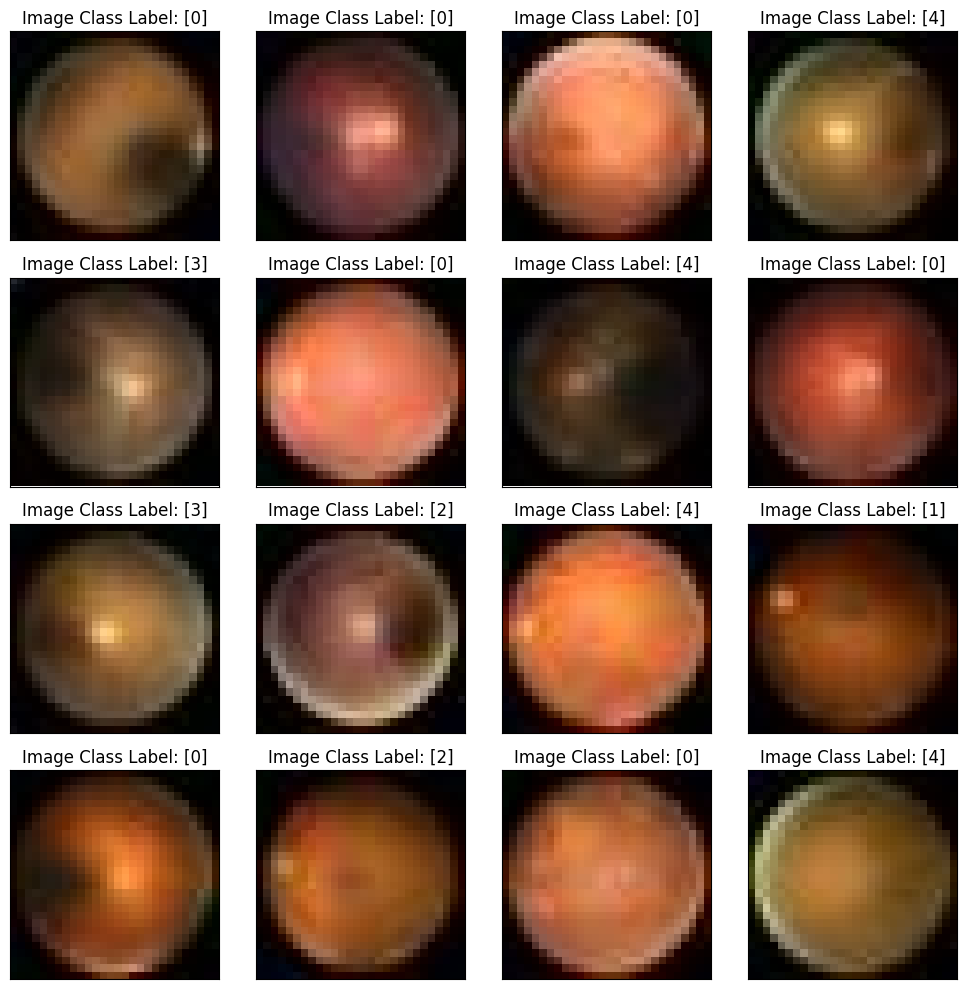

In [34]:
#Visualising Images and Classes
from numpy.ma.extras import column_stack
display_images = x_train_retina_res
display_labels = y_train_retina_res

# Define the number of rows and columns for displaying images
rows = 4
cols = 4
num_images = rows * cols

# Create a figure object with specified size and display the images
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(display_images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Image Class Label: {display_labels[i]}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [35]:
#Converting the type as float
x_train_retina_res = x_train_retina_res.astype('float32')
x_test_retina_res = x_test_retina_res.astype('float32')
val_images_retina_res = val_images_retina_res.astype('float32')

In [36]:
# Resize the images to 32,32,3
x_train_retina_res = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in x_train_retina_res])
x_test_retina_res = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in x_test_retina_res])
val_images_retina_res = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in val_images_retina_res])

#Displaying the shape
x_train_retina_res.shape, x_test_retina_res.shape

((1080, 32, 32, 3), (400, 32, 32, 3))

In [37]:
#converting our values from range[0,255] to range[0,1]
x_train_retina_res /= 255.0
x_test_retina_res /= 255.0

In [38]:
from keras.utils import to_categorical
#Tranforming our data to categorically.
num_classes = 5
y_train_retina_res = to_categorical(y_train_retina_res, num_classes)
y_test_retina_res = to_categorical(y_test_retina_res, num_classes)

In [39]:
#preprocessing the data
x_train_retina_res=preprocess_input(x_train_retina_res)
x_test_retina_res=preprocess_input(x_test_retina_res)

In [40]:
class_labels = [
    "0",
    "1",
    "2",
    "3",
    "4"
]

In [41]:
#Building Nueral network model
resnet_model=ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3))

#adding layers to our model
x = resnet_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

#plotting the summary
model = Model(inputs=resnet_model.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [42]:
# Freeze the base model layers
for layer in resnet_model.layers:
    layer.trainable = False

In [43]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
#Fitting  neural network model to the dataset.
batch_size = 32
epochs = 30
model.fit(x_train_retina_res, y_train_retina_res, batch_size=batch_size, epochs=epochs, validation_data=(x_test_retina_res,y_test_retina_res),shuffle=True)

Epoch 1/30
34/34 [==============================] - 90s 3s/step - loss: 1.4963 - accuracy: 0.4213 - val_loss: 1.4166 - val_accuracy: 0.4350
Epoch 2/30
34/34 [==============================] - 89s 3s/step - loss: 1.4175 - accuracy: 0.4500 - val_loss: 1.4245 - val_accuracy: 0.4350
Epoch 3/30
34/34 [==============================] - 87s 3s/step - loss: 1.4289 - accuracy: 0.4500 - val_loss: 1.3983 - val_accuracy: 0.4350
Epoch 4/30
34/34 [==============================] - 87s 3s/step - loss: 1.4016 - accuracy: 0.4500 - val_loss: 1.4117 - val_accuracy: 0.4350
Epoch 5/30
34/34 [==============================] - 88s 3s/step - loss: 1.4060 - accuracy: 0.4500 - val_loss: 1.4220 - val_accuracy: 0.4350
Epoch 6/30
34/34 [==============================] - 90s 3s/step - loss: 1.4110 - accuracy: 0.4500 - val_loss: 1.4386 - val_accuracy: 0.4350
Epoch 7/30
34/34 [==============================] - 91s 3s/step - loss: 1.4057 - accuracy: 0.4500 - val_loss: 1.4130 - val_accuracy: 0.4350
Epoch 8/30
34/34 [==

In [45]:
model.save("RETINA_BEST_MODEL.h5")

In [46]:
#creating our confusion matrix for our dataset
y_pred_retina_res = model.predict(x_test_retina_res)
y_pred_retina_res = np.argmax(y_pred_retina_res, axis=1)
y_test_retina_res = np.argmax(y_test_retina_res, axis=1)
cm = confusion_matrix(y_test_retina_res, y_pred_retina_res)
print(cm)

13/13 [==============================] - 5s 375ms/step
[[173   0   0   1   0]
 [ 46   0   0   0   0]
 [ 90   0   0   2   0]
 [ 67   0   0   1   0]
 [ 20   0   0   0   0]]


In [47]:
#Evaluation scores
precision = precision_score(y_test_retina_res, y_pred_retina_res,average = 'macro')
accuracy = balanced_accuracy_score(y_test_retina_res, y_pred_retina_res)
recall = recall_score(y_test_retina_res, y_pred_retina_res,average = 'macro')
f1 = f1_score(y_test_retina_res, y_pred_retina_res,average = 'macro')


print("The precision score for Retina Dataset RESNET50 Model is: ", precision)
print("The accuracy score for Retina Dataset RESNET50 Model is: ", accuracy)
print("The recall score for Retina Dataset RESNET50 Model is: ", recall)
print("The f1 score for Retina Dataset RESNET50 Model is: ", f1)

The precision score for Retina Dataset RESNET50 Model is:  0.13737373737373737
The accuracy score for Retina Dataset RESNET50 Model is:  0.2017917511832319
The recall score for Retina Dataset RESNET50 Model is:  0.2017917511832319
The f1 score for Retina Dataset RESNET50 Model is:  0.12695906432748538
